# Import libraries

In [ ]:
import pandas as pd
import numpy as np

import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/scrapped_data.csv", index_col=0,encoding="utf-8")
df = df[['readmes', 'label']]

In [ ]:
#Remove duplicates
df = df.drop_duplicates()
df = df.dropna()
#Remove general
df = df[df['label'] != 'General']
df = df.reset_index(drop=True)

# Analysis labels distribution

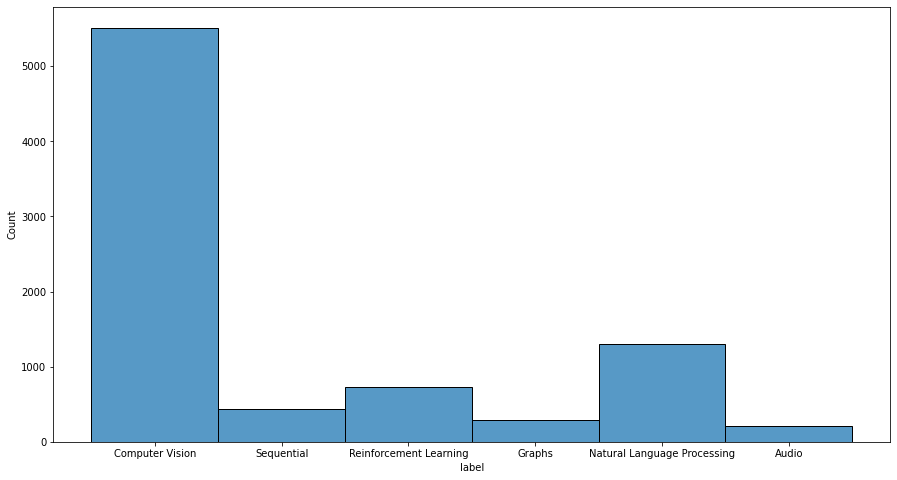

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(x='label',data=df)

In [ ]:
pd.crosstab(index=df['label'], columns='count')

col_0,count
label,
Audio,212
Computer Vision,5512
Graphs,295
Natural Language Processing,1300
Reinforcement Learning,733
Sequential,432


In [ ]:
aux = df[df.duplicated(subset='readmes', keep=False)]
aux

,readmes,label
23,b'# JAXDL: JAX (Flax) Deep Learning Library\n\...,Reinforcement Learning
50,b'# Music Generation\n## Demo\n[PLAYLIST](http...,Computer Vision
66,"b'# Music Generation\n\n<img src=""/showcase/im...",Computer Vision
67,b'# Overview\n\nPyTorch implementation of VQ-V...,Computer Vision
82,"b'<div align=""center"">\n <img src=""https://st...",Computer Vision
...,...,...
8430,"b'<div align=""center"">\n<a href=""http://camma....",Natural Language Processing
8431,b'[![PyPI version](https://badge.fury.io/py/mo...,Computer Vision
8432,b'[![PyPI version](https://badge.fury.io/py/mo...,Natural Language Processing
8453,b'# Perspective-taking and Pragmatics for Gene...,Natural Language Processing


When there are multilabeled Readmes we keep those with lower frequency. For example if we had a readme that is considered 'Graphs' and 'Computer Vision' we would keep it as 'Graphs' since we have less information about that category.

In [ ]:
#First we create a data frame without duplicates
duplicates = df[df.duplicated(subset='readmes', keep=False)]
no_duplicates =  df.drop_duplicates(subset='readmes', keep=False)

In [ ]:
#Labels in ordered frequency (min to max)
labels = ['Audio', 'Graphs', 'Sequential', 'Reinforcement Learning', 'Natural Language Processing']
for lab in labels:
  #Select multilabeled with lowest frequency
  add = duplicates[duplicates['label'] == lab]
  for i in add.index:
    #If it's not already in the dataset, add instance
    if add['readmes'][i] not in no_duplicates['readmes']:
      no_duplicates = no_duplicates.append(add.loc[i])

In [ ]:
no_duplicates = no_duplicates.reset_index(drop=True)

Final dataset shape is 8634

In [ ]:
no_duplicates.shape

(8364, 2)

# Preprocess

In depth preprocess:

In [ ]:
def cleaner(text):
    """
    Preprocess the readmes
    """
    #Remove non-asci characters
    text = re.sub(r'\\x00|\\x01|\\x02|\\x03|\\x04|\\x05|\\x06|\\x07|\\x08|\\t|\\n|\\x0b|\\x0c|\\r|\\x0e|\\x0f|\\x10|\\x11|\\x12|\\x13|\\x14|\\x15|\\x16|\\x17|\\x18|\\x19|\\x1a|\\x1b|\\x1c|\\x1d|\\x1e|\\x1f|\\x7f|\\x80|\\x81|\\x82|\\x83|\\x84|\\x85|\\x86|\\x87|\\x88|\\x89|\\x8a|\\x8b|\\x8c|\\x8d|\\x8e|\\x8f|\\x90|\\x91|\\x92|\\x93|\\x94|\\x95|\\x96|\\x97|\\x98|\\x99|\\x9a|\\x9b|\\x9c|\\x9d|\\x9e|\\x9f|\\xa0|\\xa1|\\xa2|\\xa3|\\xa4|\\xa5|\\xa6|\\xa7|\\xa8|\\xa9|\\xaa|\\xab|\\xac|\\xad|\\xae|\\xaf|\\xb0|\\xb1|\\xb2|\\xb3|\\xb4|\\xb5|\\xb6|\\xb7|\\xb8|\\xb9|\\xba|\\xbb|\\xbc|\\xbd|\\xbe|\\xbf|\\xc0|\\xc1|\\xc2|\\xc3|\\xc4|\\xc5|\\xc6|\\xc7|\\xc8|\\xc9|\\xca|\\xcb|\\xcc|\\xcd|\\xce|\\xcf|\\xd0|\\xd1|\\xd2|\\xd3|\\xd4|\\xd5|\\xd6|\\xd7|\\xd8|\\xd9|\\xda|\\xdb|\\xdc|\\xdd|\\xde|\\xdf|\\xe0|\\xe1|\\xe2|\\xe3|\\xe4|\\xe5|\\xe6|\\xe7|\\xe8|\\xe9|\\xea|\\xeb|\\xec|\\xed|\\xee|\\xef|\\xf0|\\xf1|\\xf2|\\xf3|\\xf4|\\xf5|\\xf6|\\xf7|\\xf8|\\xf9|\\xfa|\\xfb|\\xfc|\\xfd|\\xfe|\\xff',
                  ' ',str(text))
    #Remove links
    text = re.sub(r'https:\S+',' ',text)
    #Remove beginning
    text = re.sub(r'(b\")|(b\')|(\\n)', ' ', text)
    #Remove html tags
    text = re.sub(r'<[^<]+>', ' ', text)
    #Remove code blocks
    text = re.sub(r'\`\`\`[^\`]+\`\`\`', ' ', text)
    #Remove new line characters
    text = text.rstrip()
    #Remove inline code
    text = re.sub(r'\`[^\`]+\`', ' ',text)
    #Remove comands
    text = re.sub(r'--[\S]+ ', ' ',text)
    #Remove paths from root
    text = re.sub(r'C:\\\S', ' ',text)
    #Remove paths
    #considers all characters that are not <, > , : , " , / , \ , | , ? , * or blank
    text = re.sub(r'([^\<\>\:\"\/\|\?\*\s]+\/)+',' ', text)
    #Remove file names 
    text = re.sub(r'([^\<\>\:\"\/\|\?\*\s]+)\.(ipynb|py|sh|dll|exe|txt|mp4|mp3|cfg|config|avi|cmd|tar.gz)', ' ', text)
    #Remove common abbreviations
    text = re.sub(r'i\.e\.|e\.g\.|etc.',' ',text)
    #Remove special characters
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    #Remove nones
    text = re.sub(r'[Nn]one',' ',text)
    #Remove numbers (not included in words)
    text = re.sub('[0-9]+\s',' ',text)
    #Remove words with only one character
    text = re.sub(r'\b\w{1,2}\b',' ',text)
    #Substitute long space for one space
    text = re.sub(r'\s+',' ', text, flags=re.I)
    #Change text to lower case
    text = text.lower()
    return text

In [ ]:
aux = no_duplicates.copy()
aux['Tokens'] = aux['readmes'].apply(cleaner)

In [ ]:
tokenizer = ToktokTokenizer() 
#Tokenize
aux['Tokens'] = aux.Tokens.apply(tokenizer.tokenize)

In [ ]:
#Filter stopwords
STOPWORDS = set(stopwords.words("english"))

def filter_stopword_digits(tokens):
    """
    Filter stopwords and digits from a lsit of tokens
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

#Stemming
stemmer = SnowballStemmer("english")

def stem_words(tokens):
    """
    Reduce each token to its root
    """
    return [stemmer.stem(token) for token in tokens]

In [ ]:
#Remove elements with less than 10 tokens
aux = aux.drop(aux[aux['Tokens'].map(len)<10].index)
aux = aux.reset_index(drop=True)
aux['Tokens'] = aux.Tokens.apply(filtrar_stopword_digitos)
aux['Tokens'] = aux.Tokens.apply(stem_words)

# Save preprocessed dataset

In [ ]:
with open("/content/drive/MyDrive/TFM_FINAL/prep_readmes.csv", 'w', encoding = 'utf-8-sig') as f:
  aux.to_csv(f)